In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

from src.settings import Config
from src.utils import DataProcessor, Network, Results
from src.models import SpatialAggregation, TemporalAggregation
from src.visualization import Visualizer
from Full_GTEP_Solve.modules_v2 import read_data, GTEP

import pickle
import xarray as xr
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import time
import gurobipy as gp
from gurobipy import GRB

In [13]:
config = Config(
    year=2013,
    cf_k_neighbors=1,
    demand_decay_alpha=0.4,
    granularity="high_bis",
    active_features=['position', 'time_series', 'duration_curves', 'ramp_duration_curves', 'intra_correlation']
)

# Display configuration help.
config.help()

Configuration Overview:

1. Data Preproc (Immutable):
   Contains data processing parameters. Key attributes:
   - year (int): The data year (2007-2013).
   - cf_k_neighbors (int): Neighbors for capacity factor interpolation.
   - demand_decay_alpha (float): Decay factor (0 to 1) for demand adjustments.
   - active_features (list): Features to include; allowed: 'position', 'time_series', 'duration_curves',
      'ramp_duration_curves', 'intra_correlation'.
2. Model Hyper (Mutable):
   Contains model configuration parameters. Key attributes:
   - n_representative_nodes (int): Number of representative nodes.
   - k_representative_days (int): Number of representative days (1–365).
   - inter_correlation (bool): Whether inter-node correlation is included.
   - kmed_seed (int): Seed for KMedoids (0 means no seed).
   - kmed_n_init (int): Number of KMedoids initializations.
   - weights (dict): Weights for various features. Can be manually set or auto-generated based on 
      data_preproc.a

In [14]:
processor = DataProcessor(config)

Converted susceptance of 5276 transmission lines. Skipped 429 transformers.


In [37]:
data = processor.processed_data

In [16]:
data['nodes']

,bus_id,Lat,Lon
0,0,41.10,-73.62
1,1,41.10,-73.40
2,2,41.32,-73.40
3,3,41.32,-73.18
4,4,41.32,-72.96
...,...,...,...
380,380,47.04,-67.90
381,381,47.26,-69.22
382,382,47.26,-68.56
383,383,47.26,-68.34


In [38]:
data["time_series"]["demand"]

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,384
0,0.025812,1.202917,65.576928,1.296391,78.666941,4.847077,56.442781,1.086472,0.007907,0.015230,...,0.000034,0.000730,0.000978,0.000071,8.104157e-07,3.590061e-09,2.525409e-10,6.135512e-08,1.194751e-08,5.182943e-10
1,0.024299,1.132373,61.731256,1.220366,74.053622,4.562827,53.132769,1.022757,0.007444,0.014337,...,0.000032,0.000688,0.000921,0.000067,7.628899e-07,3.379527e-09,2.377309e-10,5.775703e-08,1.124686e-08,4.878996e-10
2,0.023520,1.096077,59.752562,1.181249,71.679955,4.416573,51.429686,0.989974,0.007205,0.013877,...,0.000031,0.000666,0.000891,0.000065,7.384367e-07,3.271202e-09,2.301109e-10,5.590572e-08,1.088636e-08,4.722608e-10
3,0.023171,1.079826,58.866637,1.163736,70.617188,4.351090,50.667160,0.975296,0.007098,0.013672,...,0.000031,0.000656,0.000878,0.000064,7.274883e-07,3.222701e-09,2.266991e-10,5.507683e-08,1.072495e-08,4.652588e-10
4,0.022880,1.066244,58.126220,1.149098,69.728974,4.296363,50.029876,0.963029,0.007009,0.013500,...,0.000030,0.000647,0.000867,0.000063,7.183380e-07,3.182166e-09,2.238477e-10,5.438408e-08,1.059006e-08,4.594068e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.035729,1.665044,90.769773,1.794429,108.888608,6.709190,78.126540,1.503864,0.010945,0.021081,...,0.000048,0.001011,0.001354,0.000099,1.121755e-06,4.969264e-09,3.495601e-10,8.492606e-08,1.653741e-08,7.174087e-10
8756,0.035825,1.669557,91.015780,1.799293,109.183720,6.727373,78.338280,1.507940,0.010975,0.021138,...,0.000048,0.001014,0.001358,0.000099,1.124795e-06,4.982732e-09,3.505075e-10,8.515623e-08,1.658223e-08,7.193530e-10
8757,0.035329,1.646408,89.753822,1.774345,107.669860,6.634097,77.252100,1.487032,0.010823,0.020845,...,0.000047,0.001000,0.001339,0.000098,1.109200e-06,4.913645e-09,3.456476e-10,8.397552e-08,1.635231e-08,7.093790e-10
8758,0.034468,1.606279,87.566171,1.731097,105.045524,6.472398,75.369164,1.450787,0.010559,0.020337,...,0.000046,0.000975,0.001306,0.000095,1.082164e-06,4.793880e-09,3.372228e-10,8.192871e-08,1.595374e-08,6.920886e-10


In [18]:
ntw = Network(data["nodes"], data["time_series"], config)

In [19]:
spatial = SpatialAggregation(ntw.features, config)

In [20]:
distances = spatial.distance_metrics

Computing distance metrics for 385 nodes. This might take a while...
Computing position distance...
position distance computed in 0:00:00.002173.
Computing duration_curves distance...
duration_curves distance computed in 0:00:01.214388.
Computing time_series distance...
time_series distance computed in 0:00:01.239924.
Computing ramp_duration_curves distance...
ramp_duration_curves distance computed in 0:00:01.403475.
Computing intra_correlation distance...
intra_correlation distance computed in 0:00:00.011420.
Computing inter_correlation distance...
inter_correlation distance computed in 0:00:59.757878.
All distance metrics computed.
Starting normalization...
Normalization completed in 0:00:00.
Total computation time: 0:01:03.629258.
Saving metrics...
Metrics saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\distance_metrics\v11d728cf.


In [21]:
assignment_dict = spatial.aggregate()

In [22]:
temp = TemporalAggregation(config, ntw.features, assignment_dict)

In [23]:
rep_days = temp.aggregate()

In [49]:
weights = [len(cluster_members) for cluster_members in rep_days["clusters"].values()]

In [39]:
results = Results(config, data, assignment_dict, rep_days)

Results saved to c:\Users\g630d\Documents\00_Cours\2024-2025_MIT\00 Thesis\dev\results\joint_aggregation_results\v6efb3e6a


In [25]:
visualizer = Visualizer(config, data)

In [40]:
results.results["nodes"]

,bus_id,Lat,Lon
0,52,42.20,-72.30
1,102,43.08,-71.20
2,188,44.40,-71.64
3,250,44.84,-68.78
4,347,46.38,-69.22


In [52]:
def data_cb(model, where):
    if where == gp.GRB.Callback.MIP:
        cur_obj = model.cbGet(gp.GRB.Callback.MIP_OBJBST)
        cur_bd = model.cbGet(gp.GRB.Callback.MIP_OBJBND)

        # Did objective value or best bound change?
        if model._obj != cur_obj or model._bd != cur_bd:
            model._obj = cur_obj
            model._bd = cur_bd
            model._data.append([time.time() - model._start, cur_obj, cur_bd])
            pd.DataFrame(model._data).to_csv('full_solve_log.csv')


def solve_gtep(buses, branches, params, eval_period, weights):
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 1)
        env.start()

        GTEP_data = [buses, branches]

        gtep = GTEP(env, GTEP_data, params)
        gtep.model._obj = None
        gtep.model._bd = None
        gtep.model._data = []
        gtep.model._start = time.time()
        cep_results = gtep.solve(eval_period, weights, callback=data_cb)

        return cep_results

        # with open('cep_results_v2.pkl', 'wb') as f:
        #     pickle.dump(cep_results, f)

In [54]:
buses, branches, load, pv, wind, params = read_data(results.results)
eval_period = {'Load': load, 'PV': pv, 'Wind': wind}
for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
    params[key] = params[key] * 1e-5
    
cep_results = solve_gtep(buses, branches, params, eval_period, weights)

PV shape  (240, 5)
Wind shape  (240, 5)
Load shape  (240, 5)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-06
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20427 rows, 10845 columns and 56705 nonzeros
Model fingerprint: 0xd1e2d7db
Variable types: 10840 continuous, 5 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+02]
  Objective range  [2e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-04, 5e+05]
Presolve removed 2420 rows and 2925 columns
Presolve time: 0.06s
Presolved: 18007 rows, 7920 columns, 53760 nonzeros
Variable types: 7915 continuous, 5 integer (0 binary)

Root relaxation: objective 6.525447e+02, 28539 iterations, 1.78 seconds (1.92 work units)

    Nodes    |    Current 

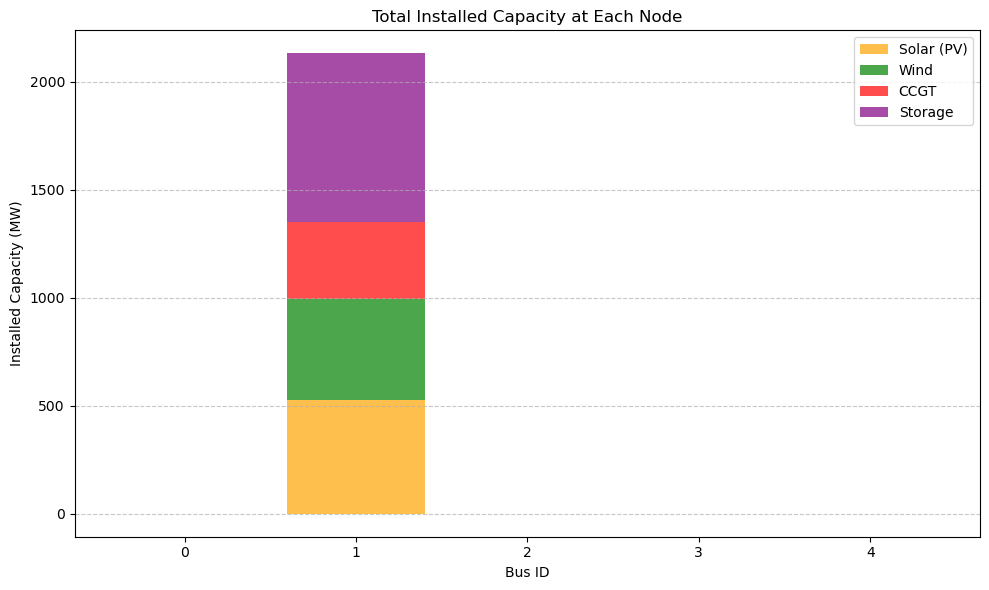

In [57]:
# Extract investments from the loaded results
pv_investment = np.array(list(cep_results["inv"]["PV"].values()))
wind_investment = np.array(list(cep_results["inv"]["Wind"].values()))
ccgt_investment = np.array(list(cep_results["inv"]["CCGT"].values())) * params['CCGT Max Cap']
storage_investment = np.array(list(cep_results["inv"]["Storage Energy"].values()))

# Calculate total capacity installed at each bus
# total_capacity = pv_investment + wind_investment + ccgt_investment + storage_investment

# Create a bar plot
bus_ids = range(len(pv_investment))  # Assuming buses are indexed from 0 to N-1
plt.figure(figsize=(10, 6))
# plt.bar(bus_ids, total_capacity, color='skyblue', label='Total Capacity (MW)')

# Add labels for individual components
plt.bar(bus_ids, pv_investment, color='orange', label='Solar (PV)', alpha=0.7)
plt.bar(bus_ids, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(bus_ids, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(bus_ids, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

# Add plot details
plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(bus_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
visualizer.plot_aggregated_network(results.results)

TypeError: Cannot index by location index with a non-integer key

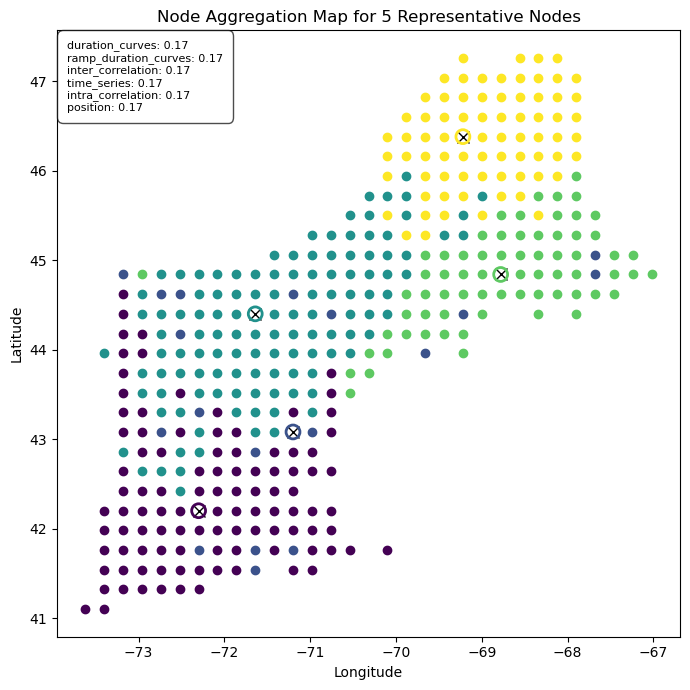

In [ ]:
visualizer.plot_spatial_clusters(assignment_dict);

In [ ]:
visualizer.plot_data(processor)

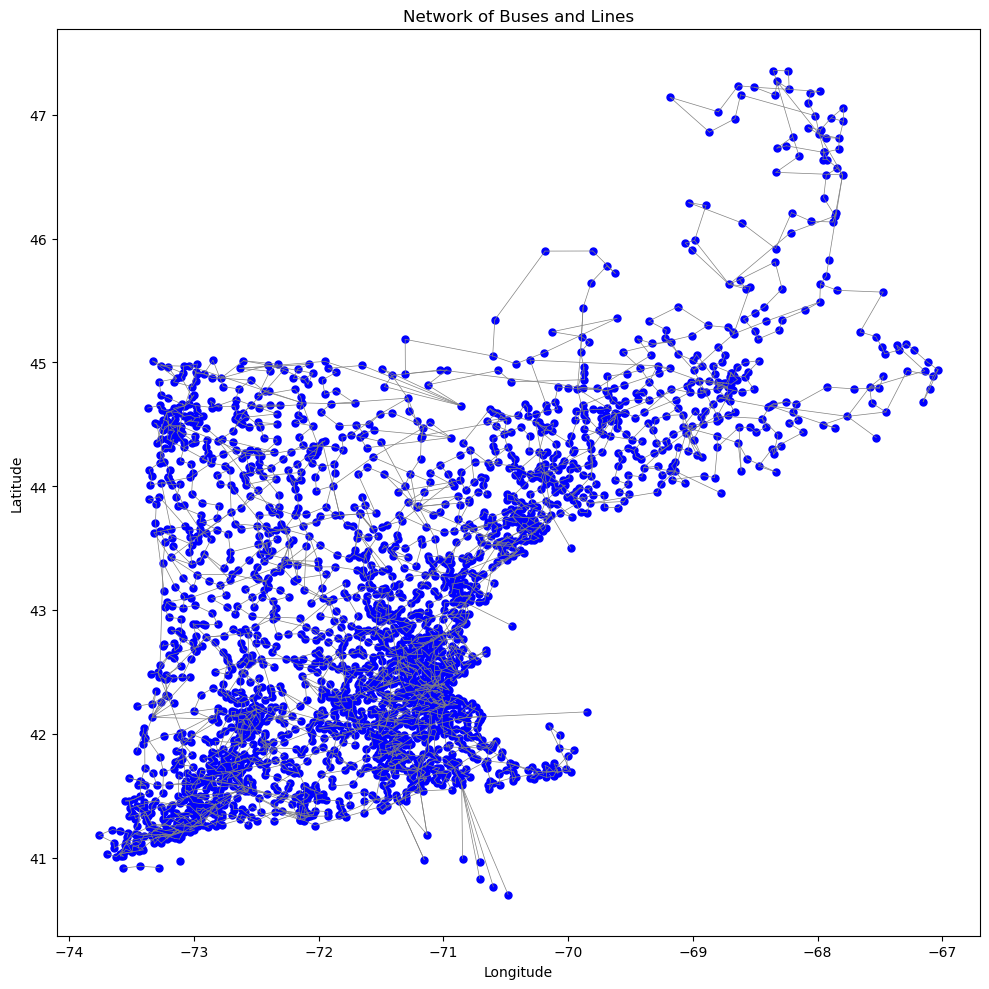

In [ ]:
visualizer.plot_network();